###  The Boston housing price dataset
 we’ll attempt to predict the median price of homes in a given Boston
suburb in the mid-1970s


Loading the Boston housing dataset

In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (
 boston_housing.load_data())

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

As you can see, we have 404 training samples and 102 test samples, each with 13
numerical features, such as per capita crime rate,

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

Normalizing the data

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Note that the quantities used for normalizing the test data are computed using the
training data. You should never use any quantity computed on the test data in your
workflow, even for something as simple as data normalization.

Building your model

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

def build_model():
   model = keras.Sequential([
   layers.Dense(64, activation="relu"),
   layers.Dense(64, activation="relu"),
   layers.Dense(1)
   ])
   model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
   return model

In [22]:

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
 print(f"Processing fold #{i}")
 val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
 val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
 partial_train_data = np.concatenate(
 [train_data[:i * num_val_samples],
 train_data[(i + 1) * num_val_samples:]],
 axis=0)
 partial_train_targets = np.concatenate(
 [train_targets[:i * num_val_samples],
 train_targets[(i + 1) * num_val_samples:]],
  axis=0)
 model = build_model()
 model.fit(partial_train_data, partial_train_targets,
 epochs=num_epochs, batch_size=16, verbose=0)
 val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
 all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [23]:
all_scores

[1.8687562942504883, 2.4086601734161377, 2.654615640640259, 2.606858015060425]

In [24]:
np.mean(all_scores)

2.3847225308418274

In [25]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
 print(f"Processing fold #{i}")
 val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
 val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
 partial_train_data = np.concatenate(
 [train_data[:i * num_val_samples],
 train_data[(i + 1) * num_val_samples:]],
 axis=0)
 partial_train_targets = np.concatenate(
 [train_targets[:i * num_val_samples],
 train_targets[(i + 1) * num_val_samples:]],
 axis=0)
 model = build_model()
 history = model.fit(partial_train_data, partial_train_targets,
 validation_data=(val_data, val_targets),
 epochs=num_epochs, batch_size=16, verbose=0)
 mae_history = history.history["val_mae"]
 all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


Building the history of successive mean K-fold validation scores

In [30]:
 all_mae_histories[0][1]

16.042428970336914

In [31]:
average_mae_history = [
 np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Plotting validation score

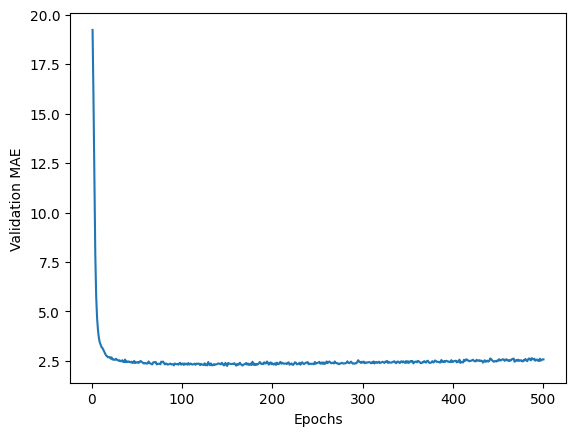

In [32]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()


Training the final model

In [33]:
model = build_model()
model.fit(train_data, train_targets,
epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.3095 - mae: 2.3751 


In [34]:
test_mae_score

2.598426103591919